# Homework 2

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


# 1. Fridge Light Failure

Imagine that you work for a company that sells fridges, with a lifetime warranty for the fridge lights. Your boss is interested in understanding the distribution of the number of lights that will fail in a given month, based on data collected over the last several years. The data were collected by hand and manually entered, so data entry errors are possible. There are also some months with missing data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

In [2]:
# Uncomment the line below if you are using Google colab
# !gdown https://drive.google.com/uc?id=1wzY4XdkcwdNdVGL42PEN0ORtzWcdj2VF

1. Read the CSV file using Pandas and store it. All you've been given are a meaningless ID and the counts of the number of fridge lights that failed in each month.

In [3]:
try:
    df = pd.read_csv("Fridge Light Data.csv")
    print(df.head())
except FileNotFoundError:
    print("The file 'Fridge Light Data.csv' was not found. Please ensure it is in the same directory as the script.")

   ID     x
0   1  24.0
1   2  33.0
2   3  31.0
3   4   NaN
4   5  31.0


2. Count the number of null values in the dataset, then remove them.

In [4]:
null_count = df.isnull().sum()
df_clean = df.dropna()
print("Number of null values in each column:\n", null_count)
print(df_clean.head())

Number of null values in each column:
 ID    0
x     4
dtype: int64
   ID     x
0   1  24.0
1   2  33.0
2   3  31.0
4   5  31.0
5   6  24.0


Number of null values: 4

3. Plot the distribution of the data. Add a title and axes labels to your plot.

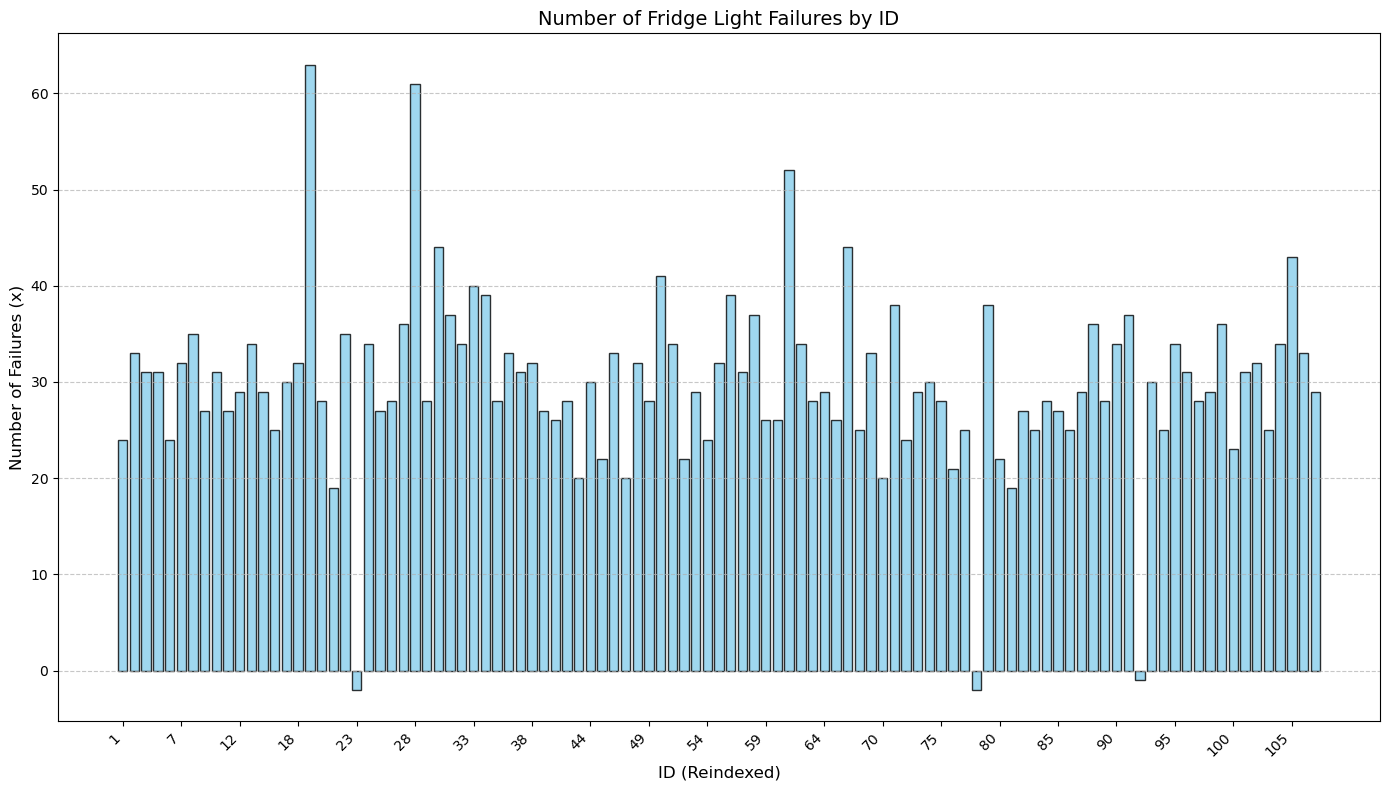

In [5]:
df_clean = df.dropna(subset=['x'])

df_clean_graph = df_clean.reset_index(drop=True) 

plt.figure(figsize=(14, 8))  
plt.bar(df_clean_graph.index, df_clean['x'], color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Number of Fridge Light Failures by ID', fontsize=14)
plt.xlabel('ID (Reindexed)', fontsize=12)  
plt.ylabel('Number of Failures (x)', fontsize=12)

step = max(1, len(df_clean_graph) // 20)  
plt.xticks(df_clean_graph.index[::step], df_clean_graph['ID'][::step], rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



4. Count the number of observations that you know with **certainty** are data entry errors, then remove them. Explain why you know they are errors.

In [6]:
error_count = (df_clean['x'] < 0).sum()
df_clean = df_clean[df_clean['x'] >= 0]
print(f"Number of negative values in the 'x' column: {error_count}")

Number of negative values in the 'x' column: 3


Number of certain data entry errors: 3

5. Compute the negative log-likelihood based on the assumption that the data comes from a Poisson($\lambda$) distribution. The negative log-likelihood for a Poisson($\lambda$) distribution is as follows:

$$
nll(\lambda) = n \lambda - \left(\sum_{i=1}^{n}x_i\right) log(\lambda) + \sum_{i=1}^{n}log(x_i!)
$$

In [7]:
import numpy as np
from scipy.special import gammaln

def poissonNegLogLikelihood(lam, x):
    return len(x) * lam - np.sum(x * np.log(lam)) + np.sum(gammaln(x + 1))
 

dummy_data = pd.DataFrame({'x': [20, 22, 18, 6, 8]})
NLL_val = poissonNegLogLikelihood(25, dummy_data.x)
print(f"Negative log-likelihood value for lambda = 25: {NLL_val:.2f}")

Negative log-likelihood value for lambda = 25: 31.19


6. Consider integer values of $\lambda$ ranging from 10 to 50. Compute the negative log-likelihood for each of these values and plot it. Include a title and axes labels on your plot. Based on the plot, what value of $\lambda$ is most likely to have generated the data? You may give a small range.

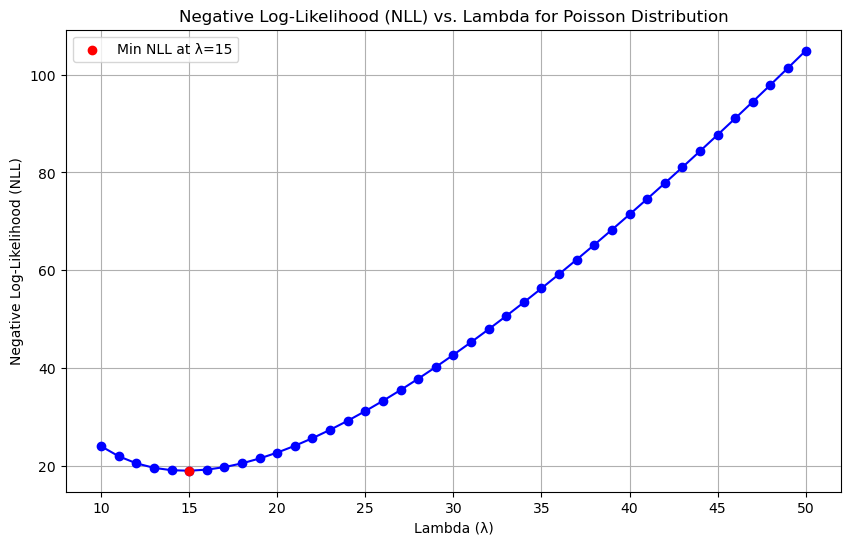

In [8]:
lambda_values = np.arange(10, 51, 1)  
NLL_values = [poissonNegLogLikelihood(lam, dummy_data['x']) for lam in lambda_values] 
    

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, NLL_values, marker='o', linestyle='-', color='blue')
plt.title('Negative Log-Likelihood (NLL) vs. Lambda for Poisson Distribution')
plt.xlabel('Lambda (λ)')
plt.ylabel('Negative Log-Likelihood (NLL)')
plt.grid(True)

min_NLL = np.min(NLL_values)
optimal_lambda = lambda_values[np.argmin(NLL_values)]
plt.scatter(optimal_lambda, min_NLL, color='red', zorder=5, label=f'Min NLL at λ={optimal_lambda}')

plt.legend()
plt.show()

Value of $\lambda$ most likely to have generated the data: 15

7. Compute the negative log-likelihood based on the assumption that the data comes from a Normal($\mu$, $\sigma$) distribution. The negative log-likelihood for a Normal($\mu$, $\sigma$) distribution is as follows:

$$
nll(\mu, \sigma) = \frac{n}{2}log(2π) + \frac{n}{2}log(\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i-\mu)^2
$$

In [9]:

def normalNegLogLikelihood(params, x):
    mu, sigma = params[0], params[1]
    return len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sigma**2) + np.sum((x - mu)**2) / (2 * sigma**2)

dummy_data = pd.DataFrame({'x': [20, 22, 18, 6, 8]})
normalNLL = normalNegLogLikelihood([25, 3], dummy_data.x)

print(f"Negative log-likelihood value for mu = 25 and sigma = 3: {normalNLL:.2f}")


Negative log-likelihood value for mu = 25 and sigma = 3: 50.81


8. Determine the exact value of $\lambda$ that minimizes the negative log-likelihood for the Poisson distribution. Use so.minimize with method="Powell" and without a Jacobian.

In [10]:
initial_lambda = 15
x = dummy_data['x'].values

result = so.minimize(
    poissonNegLogLikelihood,
    x0=initial_lambda,
    args=(x),
    method='Powell',
)

optimal_lambda = result.x[0]

print(f"Optimal lambda (Powell method): {optimal_lambda:.4f}")

Optimal lambda (Powell method): 14.8000


Value of $\lambda$ that minimizes the negative log-likelihood: 14.8000

9. Determine the set of values of $\mu$ and $\sigma$ that minimizes the negative log-likelihood for the Normal distribution.

In [11]:
initial_mu, initial_sigma = 14.8, 6.8
initial_params = [initial_mu, initial_sigma]

x = dummy_data['x'].values

result = so.minimize(
    normalNegLogLikelihood,
    x0=initial_params,
    args=(x),
    method='Powell',
)

optimal_mu, optimal_sigma = result.x[0], result.x[1]

print(f"Optimal mu (Powell method): {optimal_mu:.4f}")
print(f"Optimal sigma (Powell method): {optimal_sigma:.4f}")

Optimal mu (Powell method): 14.8000
Optimal sigma (Powell method): 6.5238


Values for $\mu$ and $\sigma$ that minimize the negative log-likelihood: 14.8000, 6.5238


10. There are three data entry errors that could potentially be valid entries. Which three are most likely to be data entry errors? Identify them by their value (i.e., not their index in the data).

In [12]:
error_values = df[df['x'] < 0]
print("Error values:", error_values)

Error values:     ID    x
22  23 -2.0
77  78 -2.0
91  92 -1.0


Three most likely data entry errors: -2.0, -2.0, and -1.0

11. Remove the three observations that you think are most likely to be data entry errors. Determine the parameters that minimize the negative log-likelihoods for the Poisson($\lambda$) and Normal($\mu$, $\sigma$) distributions. Do your results change in a meaningful way?

In [13]:
df_clean = df[df['x'] >= 0]
df_clean = df_clean.dropna(subset=['x'])

def poissonNegLogLikelihood(lam, x):
    return len(x) * lam - np.sum(x * np.log(lam)) + np.sum(gammaln(x + 1))

x = df_clean['x'].values

initial_lambda = x.sum() / len(x)

result_minimize_poisson = so.minimize(
    poissonNegLogLikelihood,
    x0=initial_lambda,
    args=(x),
    method='Powell',
)

optimal_lambda = result_minimize_poisson.x[0]

print(f"Optimal lambda (Powell method): {optimal_lambda:.4f}")

initial_params = [df_clean['x'].mean(), df_clean['x'].std()]

def normalNegLogLikelihood(params, x):
    mu, sigma = params[0], params[1]
    return len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sigma**2) + np.sum((x - mu)**2) / (2 * sigma**2)

result_minimize_normal = so.minimize(
    normalNegLogLikelihood,
    x0=initial_params,
    args=(x),
    method='Powell',
)

print(f"Optimal mu (Powell method): {result_minimize_normal.x[0]:.4f}")
print(f"Optimal sigma (Powell method): {result_minimize_normal.x[1]:.4f}")




Optimal lambda (Powell method): 30.8200
Optimal mu (Powell method): 30.8200
Optimal sigma (Powell method): 7.3489


12. Between the Poisson and Normal models, which one do you think is best to use to represent the data? Why? Provide your answer in no more than two lines.

## Written Answer

A Poisson distribution is ideal for modeling monthly fridge light failures as it accurately represents count-based, independent events over a fixed period, unlike the continuous and symmetric Normal distribution.